In [ ]:
 # https://keras.io/examples/rl/ddpg_pendulum/

In [ ]:
import gym
import tensorflow as tf
import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path

class custom_PendulumEnv(gym.Env):
    metadata = {
        'render.modes' : ['human', 'rgb_array'],
        'video.frames_per_second' : 30
    }

    def __init__(self):
        self.max_speed=8
        self.max_torque=2.
        self.dt=.05
        self.NumIntegrationsSteps = 20#5
        self.viewer = None
        self.max_step = 200
        self.current_step = 0

        high = np.array([1., 1., self.max_speed])
        self.action_space = spaces.Box(low=-self.max_torque, high=self.max_torque, shape=(1,))
        self.observation_space = spaces.Box(low=-high, high=high)

        self.seed()

        ### Customization changes ############################
        self.MRAC = ModelRefAC()
        self.MRAC.timeSample = self.dt/self.NumIntegrationsSteps
        self.MRAC.plant.tau1 = self.dt/self.NumIntegrationsSteps
        self.MRAC.ref_model.tau1 = self.dt/self.NumIntegrationsSteps
        self.wanted_torque = 0
        ####


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self,action):
        th, thdot = self.state # th := theta
        newth, newthdot = self.state # th := theta

        g = 10.
        m = 1.
        l = 1.
        dt = self.dt/self.NumIntegrationsSteps

        wanted_torque = np.clip(action, -self.max_torque, self.max_torque)[0] #numpy.clip() function is used to Clip (limit) the values in an array
        #wanted_torque = 0.135*self.wanted_torque+0.865*wanted_torque
        self.wanted_torque = wanted_torque
        self.MRAC.r = wanted_torque
        for n in np.arange(start=0, stop=self.NumIntegrationsSteps, step=1):
          self.MRAC.plant.thetadot = newthdot
          actual_torque = self.MRAC.step(r=wanted_torque)
          newthdot = newthdot + (-3*g/(2*l) * np.sin(th + np.pi) + 3./(m*l**2)*actual_torque) * dt
          newth = newth + newthdot*dt
          newthdot = np.clip(newthdot, -self.max_speed, self.max_speed) #pylint: disable=E1111 #numpy.clip() function is used to Clip (limit) the values in an array

        self.last_u = actual_torque
        costs = angle_normalize(th)**2 + .1*thdot**2 + .001*(actual_torque**2)
        self.state = np.array([newth, newthdot])

        self.current_step += 1
        done = bool(self.current_step % self.max_step == 0)

        #return self._get_obs(), -costs, done, {} , u , u_after_pid
        return self._get_obs(), -costs, done, {} , wanted_torque , actual_torque


    def reset(self):
        high = np.array([np.pi, 1])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None

        self.MRAC.reset()
        self.MRAC.plant.reset()
        self.MRAC.ref_model.reset()
        self.wanted_torque = 0

        return self._get_obs()

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot])

    def render(self, mode='human'):

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(500,500)
            self.viewer.set_bounds(-2.2,2.2,-2.2,2.2)
            rod = rendering.make_capsule(1, .2)
            rod.set_color(.8, .3, .3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(.05)
            axle.set_color(0,0,0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1., 1.)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi/2)
        if self.last_u:
            self.imgtrans.scale = (-self.last_u/2, np.abs(self.last_u)/2)

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer: self.viewer.close()

def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

In [ ]:
class ElectricalDCMotorEnv():

  def __init__(self):
    self.Resistor_R = 1.0
    self.inductor_L = 0.1
    self.torque_const_Kt = 1.0
    self.bemf_const_Ke = 1.0
    self.tau1 = 0.05
        #
    self.current = 0.0
    self.voltage_input = None
    self.thetadot = 0.0

  def step(self, u):
    voltage_BEMF = self.thetadot*self.bemf_const_Ke
    self.voltage_input = np.clip(u, -10, 10)

    f1 = self.torque_const_Kt*self.current
    self.current += self.tau1*(self.voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
    f2 = self.torque_const_Kt*self.current
    F = f2
    return F # return actual applied torque

  def reset(self):
    self.current = 0.0


In [ ]:
class ReferenceModel():

  def __init__(self):
    self.a_m = 50.0#30.0
    self.b_m = self.a_m
    self.tau1 = 0.05
    self.x_m = 0.0
    self.y_m = 0.0

  def step(self, r):

    #fwd integration
    #A = -self.a_m*self.tau1
    #Br = self.b_m*self.tau1*r
    #self.y_m = self.x_m+0
    #self.x_m = (1+A)*self.y_m+Br
    #y_m = self.y_m+0

    #bkwd integration
    #A = -self.a_m*self.tau1
    #Br = self.b_m*self.tau1*r
    #if A ==1:
    #  C=1
    #else:
    #  C = 1/(1-A)
    #self.y_m = C*(self.x_m-Br)
    #self.x_m = self.y_m+0
    #y_m = self.y_m+0

    #trapz integragration
    A = -0.5*self.a_m*self.tau1
    Br= +0.5*self.b_m*self.tau1*r
    if A ==1:
      C=1
    else:
      C = 1/(1-A)
    x_m = self.x_m
    y_m = C*(x_m+Br)
    x_m = (1+A)*y_m + Br
    self.x_m = x_m
    self.y_m = y_m

    return y_m

  def reset(self):
    self.x_m = 0.0
    self.y_m = 0.0




In [ ]:
class ModelRefAC:

  def __init__(self): #  order of signals [r,y,r-y,w]
    self.plant = ElectricalDCMotorEnv()
    self.ref_model = ReferenceModel()
    self.w = 0.0
    self.u = 0.0
    self.r = 0.0
    self.y = 0.0
    self.y_m = 0.0

    #self.adaptation_gain=np.array([5,5,5,5]) # positive scalar or np.array shape (4,)
    self.adaptation_gain=np.array([5,5,1,5])
    self.sigma_mod_adapt_gain=0 # non-neg scalar or np.array shape (4,)
    self.emod_adapt_gain=0
    self.dead_zone_threshold = 0*1e-10
    self.dead_zone_adapt_gain = 1e-6
    self.timeSample=0.05
    self.mu0 = np.array([1e-3,-1e-3,1e-3,1e-3])
    self.std = 0*1e-6
    self.k_temp = self.mu0
    self.k_hat =  self.mu0
    self.keep_coeff = True
    self.mask = np.array([True,True,True,True])
    self.distrib = np.random.standard_normal


  def step(self, r):
    self.r = r
    self.w = self.plant.thetadot
    y = self.y
    y_m = self.y_m
    e=y-y_m
    u = self.adaptationControlLaw(e=e, r=r, y=y, w=self.w)
    self.y_m = self.ref_model.step(r)
    self.y = self.plant.step(u)
    return self.y

  def adaptationControlLaw(self, e, r, y, w):
    v = np.array([r,y,r-y,w])#.clip(-20,20)
    e_norm = abs(e)

    #fwd integration
    #A = -(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    #Bev = -self.adaptation_gain*self.timeSample*e*v
    #if e_norm<=self.dead_zone_threshold:
    #  A = A*self.dead_zone_adapt_gain
    #  Bev = Bev*self.dead_zone_adapt_gain
    #self.k_hat = self.k_temp*self.mask
    #self.k_temp = ((1+A)*self.k_hat + Bev)*self.mask

    #backwd integration
    #A = -(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    #Bev = -self.adaptation_gain*self.timeSample*e*v
    #if e_norm<=self.dead_zone_threshold:
    #  A = A*self.dead_zone_adapt_gain
    #  Bev = Bev*self.dead_zone_adapt_gain
    #C = 1-A*(A!=np.ones_like(A))
    #C = 1/C
    #self.k_hat = C*(self.k_temp+Bev)*self.mask
    #self.k_temp = A*self.k_hat*self.mask

    #trapz integration
    A = -0.5*(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    Bev = -0.5*self.adaptation_gain*self.timeSample*e*v
    if e_norm<=self.dead_zone_threshold:
      A = A*self.dead_zone_adapt_gain
      Bev = Bev*self.dead_zone_adapt_gain
    if A ==1:
      C=1
    else:
      C = 1/(1-A)
    self.k_hat = C*((self.k_temp +Bev)*self.mask)
    self.k_temp = ((1+A)*self.k_hat +Bev)*self.mask
    u = np.dot(v,self.k_hat)
    u=np.clip(u,-10,10)
    self.u = u
    return u

  def reset(self):
    self.w = 0.0
    self.r = 0.0
    self.y = 0.0
    self.y_m = 0.0
    mu0 = self.mu0
    sigma0 = self.std
    keep_coeff = self.keep_coeff
    self.k_temp = (sigma0*self.distrib(self.k_temp.shape) + keep_coeff*self.k_temp + (not keep_coeff)*mu0)*self.mask
    self.k_hat = (sigma0*self.distrib(self.k_hat.shape) + keep_coeff*self.k_hat + (not keep_coeff)*mu0)*self.mask


In [ ]:
env = custom_PendulumEnv()

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
print("dt= ", env.dt)
print("N= ", env.NumIntegrationsSteps)
print("dt/N=", env.dt/env.NumIntegrationsSteps)
print("gamma*dt/N=", env.MRAC.adaptation_gain*env.dt/env.NumIntegrationsSteps)

dt=  0.05
N=  20
dt/N= 0.0025
gamma*dt/N= [0.0125 0.0125 0.0025 0.0125]


In [ ]:
'''
problem = "Pendulum-v1"
env = gym.make(problem)
'''


num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [ ]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -keras.ops.mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)

In [ ]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [ ]:

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound) #numpy.clip() function is used to Clip (limit) the values in an array

    return [np.squeeze(legal_action)]


In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000#500
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

In [ ]:
#######################################################tests
prev_state = env.reset()
print(prev_state)
print(type(prev_state))

[0.97778816 0.20959558 0.2966066 ]
<class 'numpy.ndarray'>


In [ ]:
total_episodes=300
print_episode_each=1

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

In [ ]:
save_observation = []
save_wanted_torque = [0]
save_actual_torque = [0]
save_model_torque = [0]
save_ctrl_voltage = []
save_MRAC_adapt_gains = []

ploting_adapt_coeff=[]
k_hat_print = env.MRAC.mu0
print('Initial adapt. coeffs: ', k_hat_print)

initial_not_saved = True
# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        k_hat_print = env.MRAC.k_hat.round(2)
        if ep == total_episodes - 1 and initial_not_saved:
          save_MRAC_adapt_gains.append(env.MRAC.k_hat)
          save_observation.append(prev_state)
          u0=env.MRAC.adaptationControlLaw(e=env.MRAC.y-env.MRAC.y_m,
                                              r=env.MRAC.r,y=env.MRAC.y,
                                              w=env.MRAC.w)
          save_ctrl_voltage.append(u0)
          initial_not_saved = False
       #end if

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)

        # Recieve state and reward from environment.
        state, reward, done, info , wanted_torque , actual_torque = env.step(action)
        voltage = env.MRAC.plant.voltage_input


        if ep == total_episodes - 1 :
          save_observation.append(state)
          save_wanted_torque.append(wanted_torque)
          save_actual_torque.append(actual_torque)
          save_model_torque.append(env.MRAC.y_m)
          save_ctrl_voltage.append(env.MRAC.u)
          save_MRAC_adapt_gains.append(env.MRAC.k_hat)
        #end if


        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    ploting_adapt_coeff.append(k_hat_print)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    if ep%print_episode_each == 0 or ep == total_episodes - 1:
      print(f"Episode * {ep} * "," adapt. coeffs at final time step: ", k_hat_print)
      if ep%10==0 and ep>0:
        k_hat_median = np.median(np.array(ploting_adapt_coeff), axis=0)
        print("median: ", k_hat_median)
      print("Episode * {} * Avg Reward is ==> {:.3f}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)



Initial adapt. coeffs:  [ 0.001 -0.001  0.001  0.001]
Episode * 0 *   adapt. coeffs at final time step:  [ 0.36 -0.37  0.15  1.03]
Episode * 0 * Avg Reward is ==> -1097.036
Episode * 1 *   adapt. coeffs at final time step:  [ 1.1  -0.18  0.26  0.86]
Episode * 1 * Avg Reward is ==> -1496.817
Episode * 2 *   adapt. coeffs at final time step:  [ 1.13 -0.18  0.26  0.97]
Episode * 2 * Avg Reward is ==> -1593.362
Episode * 3 *   adapt. coeffs at final time step:  [ 1.27 -0.17  0.29  1.  ]
Episode * 3 * Avg Reward is ==> -1552.443
Episode * 4 *   adapt. coeffs at final time step:  [ 1.22 -0.23  0.29  1.  ]
Episode * 4 * Avg Reward is ==> -1424.913
Episode * 5 *   adapt. coeffs at final time step:  [ 1.24 -0.27  0.3   1.  ]
Episode * 5 * Avg Reward is ==> -1344.770
Episode * 6 *   adapt. coeffs at final time step:  [ 1.34 -0.31  0.33  1.09]
Episode * 6 * Avg Reward is ==> -1361.204
Episode * 7 *   adapt. coeffs at final time step:  [ 1.57 -0.56  0.43  1.2 ]
Episode * 7 * Avg Reward is ==> -133

In [ ]:
print((np.array(ploting_adapt_coeff)).mean(axis=0).round(2))
print(np.median(np.array(ploting_adapt_coeff), axis=0))

[ 3.84 -2.9   1.35  1.12]
[ 3.48 -2.52  1.2   1.06]


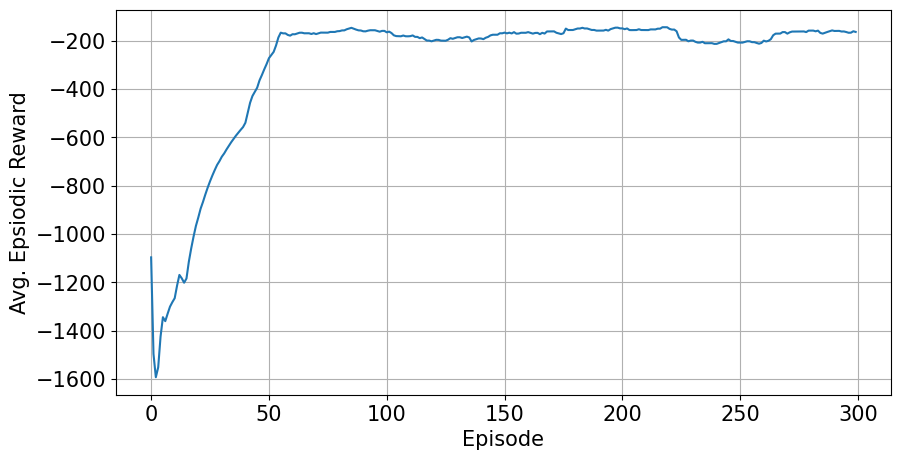

In [ ]:
# Plotting graph
# Episodes versus Avg. Rewards
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.grid()
plt.show()

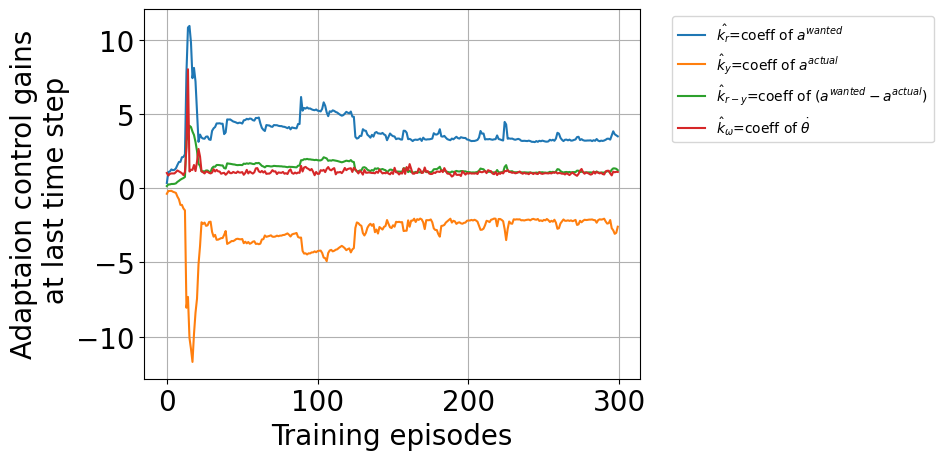

In [ ]:
font = {'size': 20}
plt.rc('font', **font)
plt.plot(ploting_adapt_coeff)
plt.xlabel("Training episodes")
plt.ylabel("Adaptaion control gains\n at last time step")
#plt.rc('axes', labelsize=30)

plt.grid()
plt.legend(labels=[r"$\hat{k_r}$=coeff of $a^{wanted}$",
                   r"$\hat{k}_y$=coeff of $a^{actual}$",
                 r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$",
                 r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"], fontsize=10
           , bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

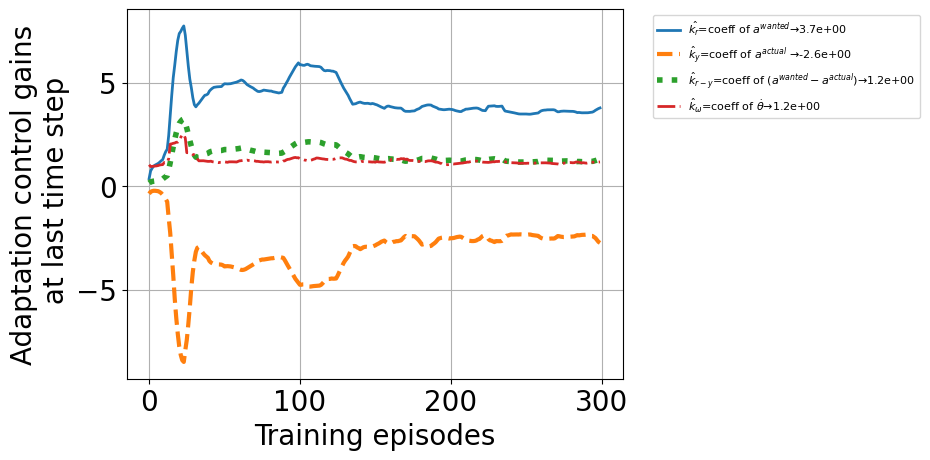

In [ ]:
N=10
# Compute the moving average of the last 50 numbers
moving_average = []
for i, n in enumerate(ploting_adapt_coeff):
    if i < N:
        # If there are not enough previous elements,
        # append the average of all available elements
        avg = sum(ploting_adapt_coeff[:i+1]) / (i+1)
    else:
        # Otherwise, compute the average of the previous 5 elements
        avg = sum(ploting_adapt_coeff[i-N:i+1]) / N
    moving_average.append(avg)
moving_average = np.array(moving_average).T
# Plot the moving average
#f"→{moving_average[0,-20:-1].mean()"
plt.plot(moving_average[0]
         ,label = r"$\hat{k_r}$=coeff of $a^{wanted}$"+f"→{moving_average[0,-5:-1].mean():.1e}",color="C0",linewidth = 2)
plt.plot(moving_average[1],'--',
         label = r"$\hat{k}_y$=coeff of $a^{actual}$ "+f"→{moving_average[1,-5:-1].mean():.1e}",color="C1",linewidth = 3)
plt.plot(moving_average[2],':',
         label = r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$"+f"→{moving_average[2,-5:-1].mean():.1e}",
         color="C2",linewidth = 4)
plt.plot(moving_average[3],'-.',
         label = r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"+f"→{moving_average[3,-5:-1].mean():.1e}"
         ,color="C3",linewidth = 2)
#plt.plot(moving_average)
plt.xlabel("Training episodes")
plt.ylabel("Adaptation control gains\n at last time step")
plt.grid()
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.weights.h5")
critic_model.save_weights("pendulum_critic.weights.h5")

target_actor.save_weights("pendulum_target_actor.weights.h5")
target_critic.save_weights("pendulum_target_critic.weights.h5")

In [ ]:
#!pip install latex

In [ ]:
dt=env.dt

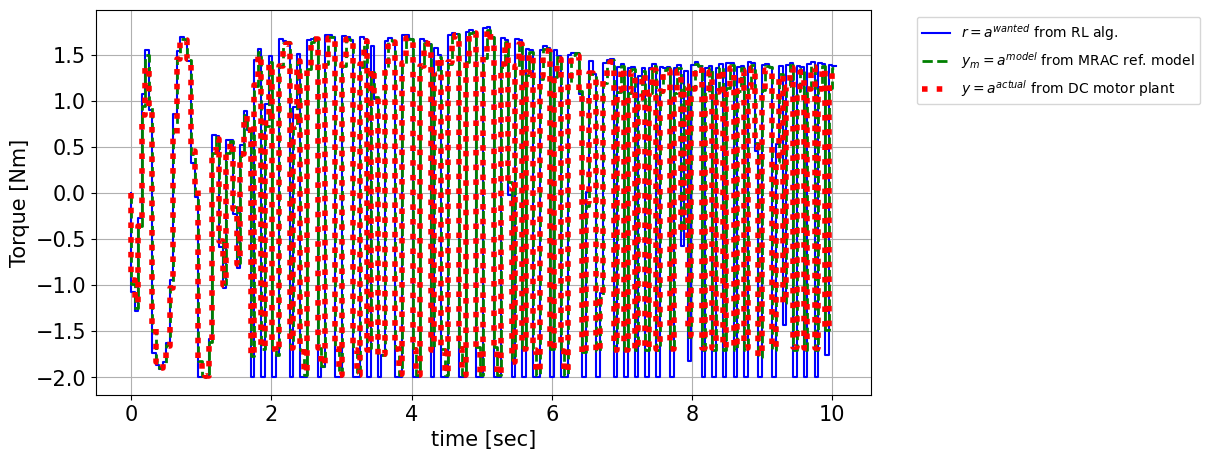

In [ ]:
time_ = np.linspace(start = 0, stop = len(save_actual_torque)* dt,num=len(save_actual_torque) )

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


plt.step(time_, save_wanted_torque ,label = r"$r=a^{wanted}$ from RL alg.",color="blue",linewidth = 1.5)
plt.step(time_, save_model_torque , '--',label = "$y_m=a^{model}$ from MRAC ref. model",color="green",linewidth = 2)
plt.step(time_, save_actual_torque , ':',label = "$y=a^{actual}$ from DC motor plant",color="red",linewidth = 4)
plt.xlabel("time [sec]")
plt.ylabel("Torque [Nm]")
plt.legend(fontsize=10,bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.show()

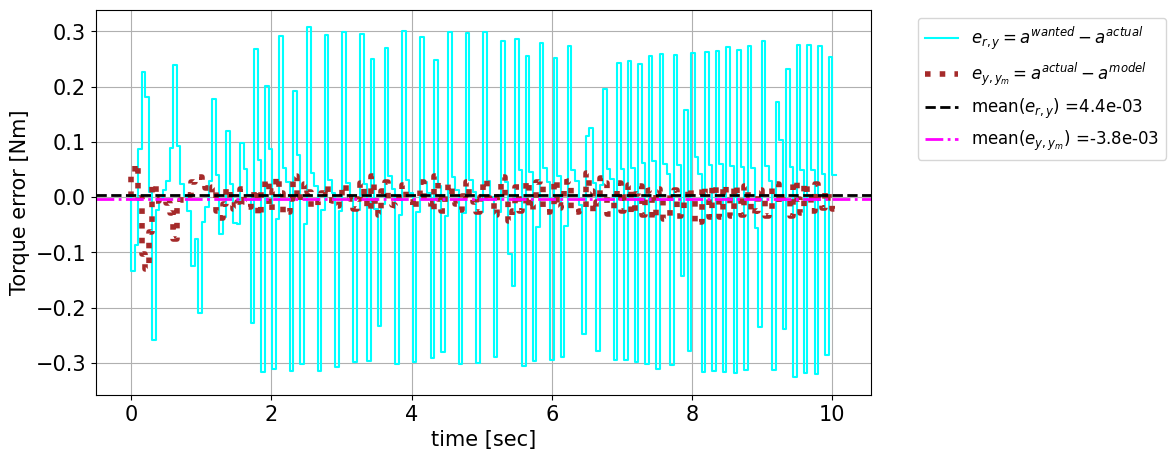

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_torque)-np.array(save_actual_torque)
e_yy_m=np.array(save_actual_torque)-np.array(save_model_torque)


plt.step(time_, e_ry ,label = "$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)
plt.axhline(y=e_ry.mean(), color="black",linewidth = 2, linestyle='--', label='mean($e_{r,y}$) =' +f'{e_ry.mean():.1e}')
plt.axhline(y=e_yy_m.mean(), color="magenta",linewidth = 2, linestyle='-.', label='mean($e_{y,y_m}$) =' +f'{e_yy_m.mean():.1e}')


plt.xlabel("time [sec]")
plt.ylabel("Torque error [Nm]")
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.show()

In [ ]:
from scipy.integrate import cumulative_trapezoid

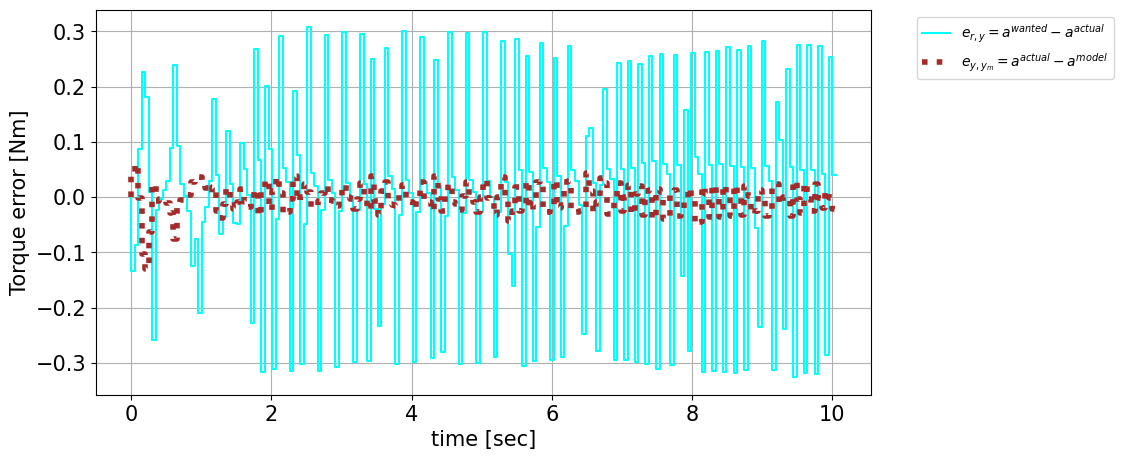

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_torque)-np.array(save_actual_torque)
e_yy_m=np.array(save_actual_torque)-np.array(save_model_torque)


plt.step(time_, e_ry ,label = r"$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)

plt.xlabel("time [sec]")
plt.ylabel("Torque error [Nm]")
plt.legend(fontsize=10,bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.show()

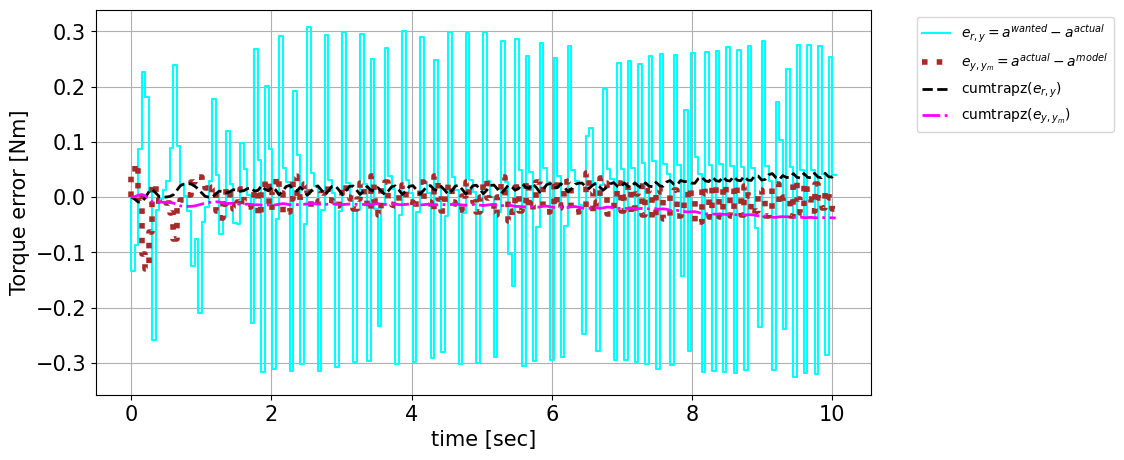

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_torque)-np.array(save_actual_torque)
e_yy_m=np.array(save_actual_torque)-np.array(save_model_torque)

cum_trapz_e_ry = cumulative_trapezoid(y=np.r_[0,e_ry],x=None, dx=dt)
cum_trapz_e_yy_m = cumulative_trapezoid(y=np.r_[0,e_yy_m],x=None, dx=dt)


plt.step(time_, e_ry ,label = r"$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)

plt.plot(time_, cum_trapz_e_ry,'--',
         label = r"cumtrapz($e_{r,y}$)",color="black",linewidth = 2)
plt.plot(time_, cum_trapz_e_yy_m,'-.',
         label = r"cumtrapz($e_{y,y_m}$)",color="magenta",linewidth = 2)

plt.xlabel("time [sec]")
plt.ylabel("Torque error [Nm]")
plt.legend(fontsize=10,bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.show()

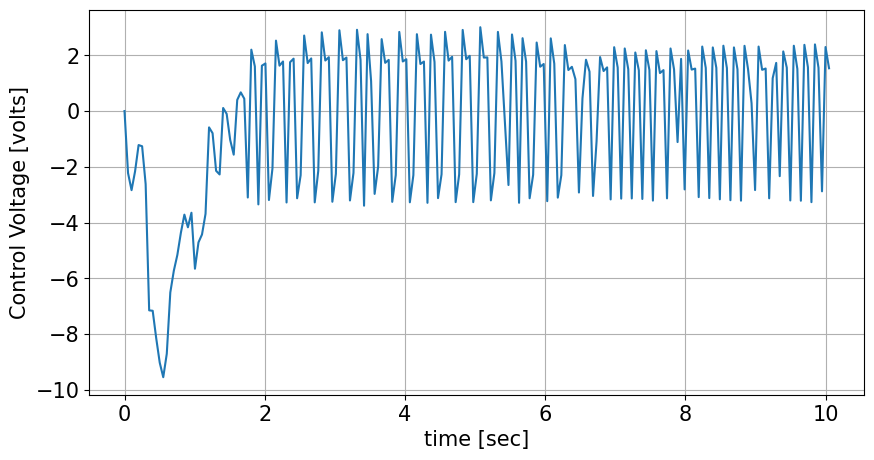

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(time_, save_ctrl_voltage)
plt.xlabel("time [sec]")
plt.ylabel("Control Voltage [volts]")
plt.grid()
plt.show()

In [ ]:
np_array_MRAC_adapt_gains = np.array(save_MRAC_adapt_gains).T

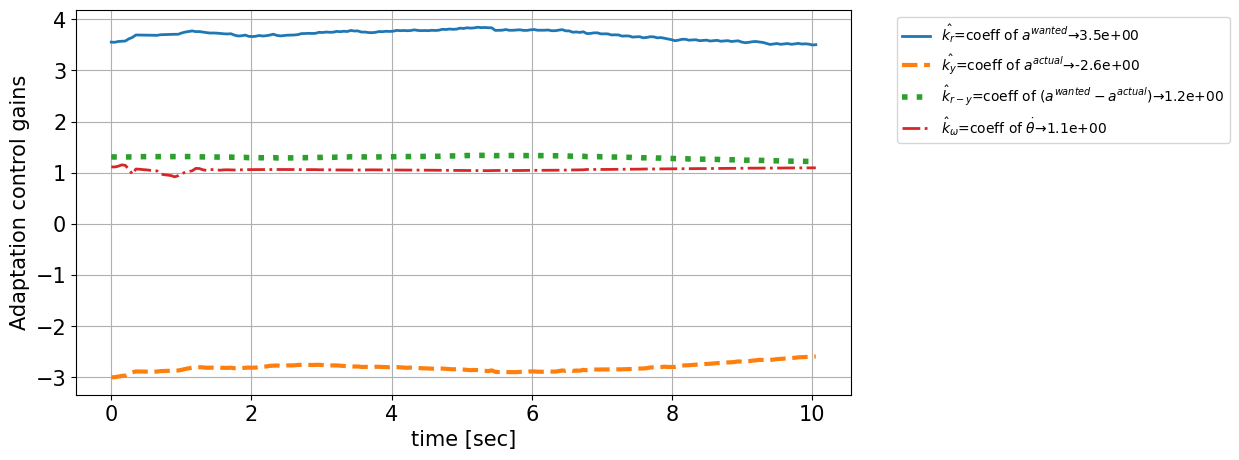

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

plt.plot(time_, np_array_MRAC_adapt_gains[0]
         ,label = r"$\hat{k_r}$=coeff of $a^{wanted}$"+f"→{np_array_MRAC_adapt_gains[0,-20:-1].mean():.1e}",color="C0",linewidth = 2)
plt.plot(time_, np_array_MRAC_adapt_gains[1],'--'
         ,label = r"$\hat{k_y}$=coeff of $a^{actual}$"+f"→{np_array_MRAC_adapt_gains[1,-20:-1].mean():.1e}",color="C1",linewidth = 3)
plt.plot(time_, np_array_MRAC_adapt_gains[2],':',
         label = r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$"+f"→{np_array_MRAC_adapt_gains[2,-20:-1].mean():.1e}",color="C2",linewidth = 4)
plt.plot(time_, np_array_MRAC_adapt_gains[3],'-.',
         label = r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"+f"→{np_array_MRAC_adapt_gains[3,-20:-1].mean():.1e}",color="C3",linewidth = 2)
plt.xlabel("time [sec]")
plt.ylabel("Adaptation control gains")
plt.grid()
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
import math

x_print = []
y_print = []
thetadot_print = []

for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      x_print.append(value)
      #theta_print.append(math.acos(value))
    if index == 1:
      y_print.append(value)
    if index == 2:
      thetadot_print.append(value)

theta_print = list(np.arctan2(np.array(y_print), np.array(x_print)))

In [ ]:
#dt=0.05
print(len(x_print))

201


In [ ]:
#dt=0.05
print(len(x_print))

201


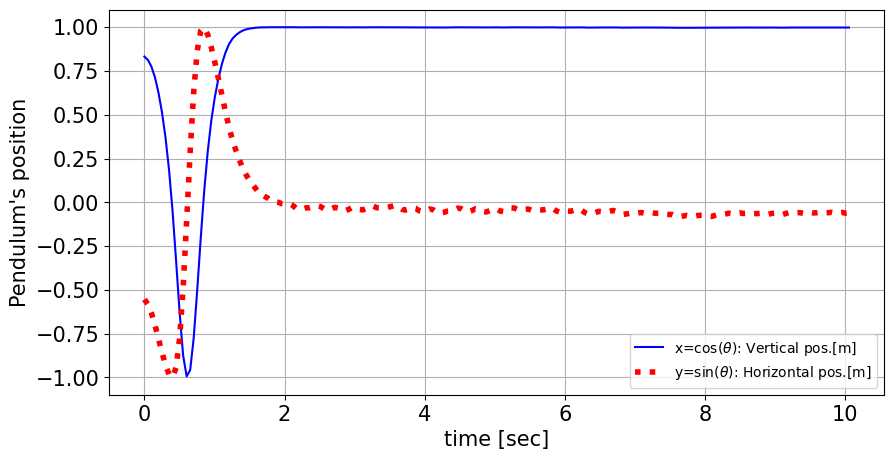

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


plt.plot(time_, x_print,
         label = r"x=cos($\theta$): Vertical pos.[m]",color="blue",linewidth = 1.5)
plt.plot(time_, y_print,':',
         label = r"y=sin($\theta$): Horizontal pos.[m]",color="red",linewidth = 4)
plt.xlabel("time [sec]")
plt.ylabel("Pendulum's position")
plt.grid()
plt.legend(fontsize=10)
plt.show()

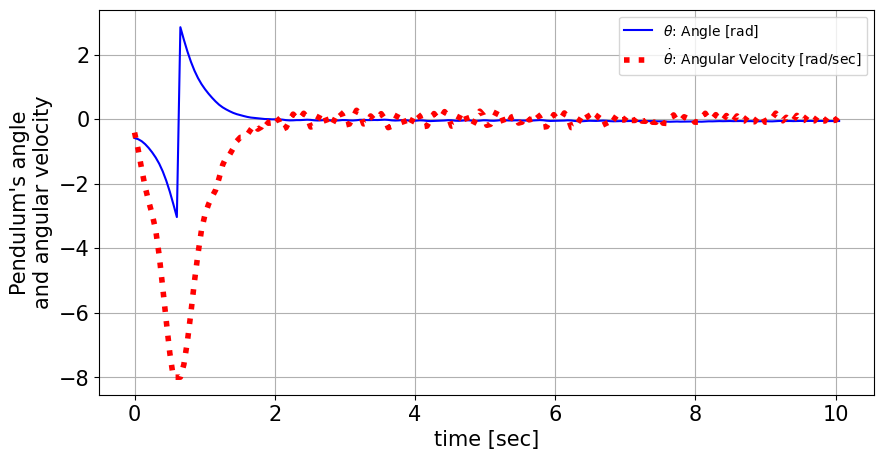

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


plt.plot(time_, theta_print,
         label = r"$\theta$: Angle [rad]",color="blue",linewidth = 1.5)
plt.plot(time_, thetadot_print,':',
         label = r"$\dot{\theta}$: Angular Velocity [rad/sec]",color="red",
         linewidth = 4)
plt.xlabel("time [sec]")
plt.ylabel("Pendulum's angle\nand angular velocity")
plt.grid()
plt.legend(fontsize=10)
plt.show()